Adversarial Examples in Physical World

In [1]:
!ls

sample_data


In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/Colab Notebooks/TPE")

In [8]:
!ls

Data	       image_utils.py			 __pycache__
data_utils.py  Inception_V3_aderversarial.ipynb  Untitled.ipynb


In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        #T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

In [5]:
#Because inception V3 is too large to be used. I can't run it in my computer. So I choose squeezenet.
model = torchvision.models.squeezenet1_0(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

[958  85 244 182 294 804 697 366 817 999 824 975 724  92 231 877 946 264
 496 812 985 813 662 883 100]


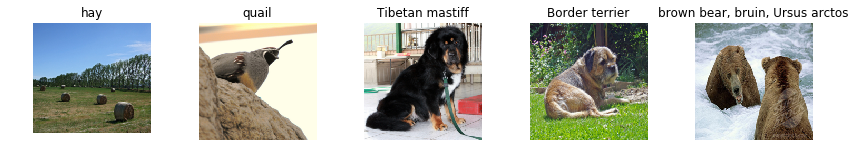

In [6]:
def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'Data/imagenet_val_25.npz'

    f = np.load(imagenet_fn)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

X, y, class_names = load_imagenet_val(num=25)
print(y)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [53]:
def fast_method(X,  model):

    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1
    eps = 16
    
    scores = model(X_fooling)
    index = torch.argmax(scores, dim = 1)
    #index = np.argmax(scores, axis = 1)
    print(index)
    
    #Fast Method
    exp_sum = torch.sum(scores.exp())
    #exp_sum = np.sum(scores.exp())
    p = scores.exp() / exp_sum
    index_p = torch.argmax(p, dim = 1) 
    #p(y|x) = p(y,x)/p(x)   p(x) = sum(p(x|y) * p(y))
    p_x = torch.sum(p)
    p_yx = p[0, index_p[0]]/p_x
    J = -torch.log(p_yx)
    J.backward()
    grad = X_fooling.grad.data

    X_fooling.data += eps * torch.from_numpy(np.sign(grad.numpy()))
    return X_fooling.data

Basic interative method

In [54]:
def clip(X1, X, eps):
    Xminus = X - eps
    ref0 = torch.zeros_like(X)
    ref255 = 255 * torch.ones_like(X)
    Xmax = torch.max(X, X1)
    Xmax = torch.max(Xmax, ref0)
    Xadd = X + eps
    Xmin = torch.min(Xmax, Xadd)
    Xmin = torch.min(Xmin, ref255)
    
    return Xmin
     

In [55]:
def basic_interative_method(X,  model):
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1
    eps = 0.01
    alpha = 1
    
    scores = model(X_fooling)
    index = torch.argmax(scores, dim = 1)
    #index = np.argmax(scores, axis = 1)
    print(index)
    n = 10
    
    for i in range(n):
        scores = model(X_fooling)
        exp_sum = torch.sum(scores.exp())
        p = scores.exp() / exp_sum
        index_p = torch.argmax(p, dim = 1) 
    #p(y|x) = p(y,x)/p(x)   p(x) = sum(p(x|y) * p(y))
        p_x = torch.sum(p)
        p_yx = p[0, index_p[0]]/p_x
        J = -torch.log(p_yx)
        J.backward()
        grad = X_fooling.grad.data
        X_fooling.data += alpha * torch.from_numpy(np.sign(grad.numpy()))
        X_fooling.data = clip(X_fooling.data, X.data, eps)
    pass
    return X_fooling.data
    

In [56]:
def Least_likely(X, y_target, model):
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    alpha = 1
    eps = 0.01
    
    
    
    pass

In [57]:
idx = 0


X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = fast_method(X_tensor[idx:idx+1], model)

scores = model(X_fooling)
index = torch.argmax(scores, dim = 1)
print(index.numpy())

tensor([958])
[879]


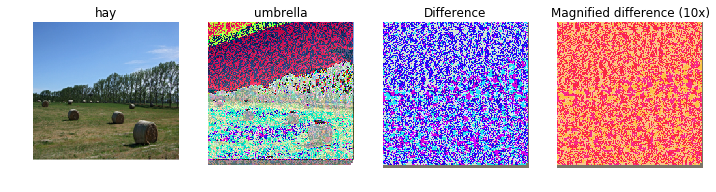

In [58]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[index.numpy()[0]])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()